<a href="https://colab.research.google.com/github/tikendraw/caption-generator/blob/main/captiongenerator_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caption Generator


In [1]:
# Dependencies
import os
if 'google.colab' in str(get_ipython()):
    ! git clone https://github.com/tikendraw/caption-generator.git -q
    os.chdir('caption-generator')

import numpy as np
import pandas as pd
import os, random, math
import tensorflow as tf
import glob
import shutil
from zipfile import ZipFile
import datetime
import sys

if not os.path.exists('funcyou'):
	! git clone https://github.com/tikendraw/funcyou -q
!pip install funcyou/. -q
!pip install numba -q

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tqdm import tqdm
from pathlib import Path
# from test_functions import count_files_by_type
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import pad_sequences
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from collections import Counter

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocessing
from tensorflow.keras.layers import (
    TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention, Flatten, Dropout,
    Concatenate, Activation, GlobalAveragePooling2D
    )
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.utils import array_to_img, img_to_array
import string
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import regex as re

# !pip install wget -q
# import wget
from funcyou.utils import dir_walk
from funcyou.dataset import download_kaggle_dataset

2023-05-13 21:24:41.257839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 21:24:43.142271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-05-13 21:24:43.142401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-05-13 21:24:43.142412: W tensorflow/compiler/tf2ten

/bin/bash: /home/t/miniconda3/envs/tf_new/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/t/miniconda3/envs/tf_new/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
# ! rm -rf funcyou

In [3]:

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()


In [4]:
# Set a seed value
seed_value = 12321

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

# tf.set_random_seed(seed_value)


In [5]:
IMG_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 5
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
EMBEDDING_DIMENSION = 50


## Downloading Dataset


In [6]:
dataset_url = Path(
    'https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset')
api_command = "kaggle datasets download -d hsankesara/flickr-image-dataset"


In [7]:
image_dir = Path('./input/flickr30k/images')
dest_caption_file_dir = Path('./input/flickr30k/results.csv')


In [8]:
# walkthrough
dir_walk('.', exclude = ['funcyou'])


,directory,base,folders,video,music,photos,application/zip,documents,others,total files
0,.,.,7,0,0,0,0,7,4,11
1,./local_config_cuda,local_config_cuda,1,0,0,0,0,0,0,0
2,./embedding,embedding,0,0,0,0,1,1,1,3
3,./drive,drive,1,0,0,0,0,0,0,0
4,./drive/MyDrive,MyDrive,1,0,0,0,0,0,0,0
5,./drive/MyDrive/caption_generator,caption_generator,2,0,0,0,0,0,0,0
6,./drive/MyDrive/caption_generator/capgen-2023-...,capgen-2023-05-13 15:32:40.515046,0,0,0,0,0,0,0,0
7,./drive/MyDrive/caption_generator/capgen-2023-...,capgen-2023-05-13 07:49:41.529097,0,0,0,0,0,0,0,0
8,./input,input,1,0,0,0,0,0,0,0
9,./input/flickr30k,flickr30k,1,0,0,0,0,1,0,1


In [9]:
def move_to_dest():
    
    # copying photos to destination directory
    src_dir = "./flickr30k_images/flickr30k_images/flickr30k_images/"
    dst_dir = "./input/flickr30k/images"
    os.makedirs(dst_dir, exist_ok=True)
    # Use glob to find all files in the source directory
    files = glob.glob(f"{src_dir}*")

    # Iterate over all files found by glob
    for file in files:
        # Extract the filename from the full file path
        filename = file.split("/")[-1]
        # Construct the full path of the destination file
        dst_path = f"{dst_dir}/{filename}"
        # Copy the file from source to destination
        shutil.copy(file, dst_path)

    # copying captionfile
    src_caption_file_dir = Path(
        "./flickr30k_images/flickr30k_images/results.csv")
    shutil.copy(src_caption_file_dir, dest_caption_file_dir)


In [10]:
# if 'google.colab' in str(get_ipython()):

    
#     # import regex as re
#     from google.colab import drive

#     # drive.mount('/content/drive')
#     # Downloading dataset
#     print("Downloading...")
#     download_kaggle_dataset(api_command, kaggle_json_filepath='./kaggle.json')
#     print("Downloaded.")
    

#     # Extracting dataset zip
#     print('Extracting...')
#     with ZipFile('flickr-image-dataset.zip') as zip:
#         zip.extractall()
#     print('Extracted.')

#     # Moving this to place
#     print('Moving...')
#     move_to_dest()
#     print('Done')


In [11]:
# walkthrough
dir_walk('.', exclude = ['funcyou', 'drive'])


,directory,base,folders,video,music,photos,application/zip,documents,others,total files
0,.,.,7,0,0,0,0,7,4,11
1,./local_config_cuda,local_config_cuda,1,0,0,0,0,0,0,0
2,./embedding,embedding,0,0,0,0,1,1,1,3
3,./input,input,1,0,0,0,0,0,0,0
4,./input/flickr30k,flickr30k,1,0,0,0,0,1,0,1
5,./input/flickr30k/images,images,0,0,0,31783,0,0,0,31783
6,./__pycache__,__pycache__,0,0,0,0,0,0,0,1
7,./log,log,0,0,0,0,0,0,0,0


In [12]:
# delete the folder to save space
# os.system('rm -rf flickr30k_image*')
# os.system('rm -rf input')


# Reading and Visualizing Image Dataset


In [13]:
image_dir = Path('./input/flickr30k/images')
caption_file = Path('input/flickr30k/results.csv')


In [14]:
df = pd.read_csv(dest_caption_file_dir, delimiter='|', on_bad_lines='skip')

# lowring and striping column names
df.columns = df.columns.str.lower().str.strip()

print('shape: ', df.shape)
df.head()


shape:  (158915, 3)


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   comment_number  158915 non-null  object
 2   comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [16]:
df.columns

Index(['image_name', 'comment_number', 'comment'], dtype='object')

In [17]:
df.drop(19999, inplace = True)
df['comment_number'] = pd.to_numeric(df['comment_number'])

In [18]:
# we are just taking one caption per image for training purpose
df = df[df.comment_number==1]

In [19]:
# Check for null values
df.isnull().sum()


image_name        0
comment_number    0
comment           0
dtype: int64

In [20]:
# dropping nulls
df.dropna(inplace=True)


In [21]:
df['serial'] = LabelEncoder().fit_transform(df['image_name'])


In [22]:
df.head(20)


,image_name,comment_number,comment,serial
1,1000092795.jpg,1,"Two young , White males are outside near many...",0
6,10002456.jpg,1,Workers look down from up above on a piece of...,1
11,1000268201.jpg,1,A little girl in a pink dress going into a wo...,2
16,1000344755.jpg,1,A man in a blue shirt is standing on a ladder...,3
21,1000366164.jpg,1,Two guy cooking and joking around with the ca...,4
26,1000523639.jpg,1,A man in green holds a guitar while the other...,5
31,1000919630.jpg,1,A man is sitting on a chair holding a large s...,6
36,10010052.jpg,1,A trendy girl talking on her cellphone while ...,7
41,1001465944.jpg,1,Three people are standing outside near large ...,8
46,1001545525.jpg,1,Two youths are jumping over a roadside railin...,9


In [23]:
print('Total images: ', df['image_name'].nunique())
print('Total images: ', df['serial'].max())


Total images:  31783
Total images:  31782


In [24]:
counts = Counter(df['image_name'])
print(np.bincount(list(counts.values())))

del(counts)


[    0 31783]


THis shows 1 photo has 4 captions while rest(31782) have 5 captions


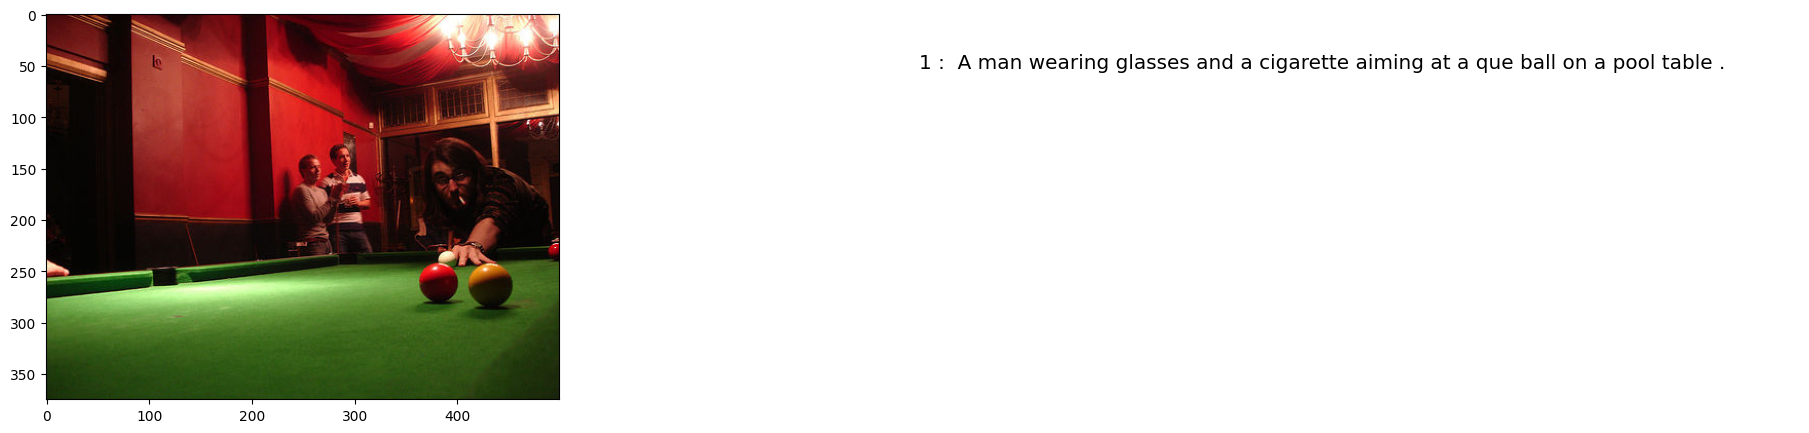

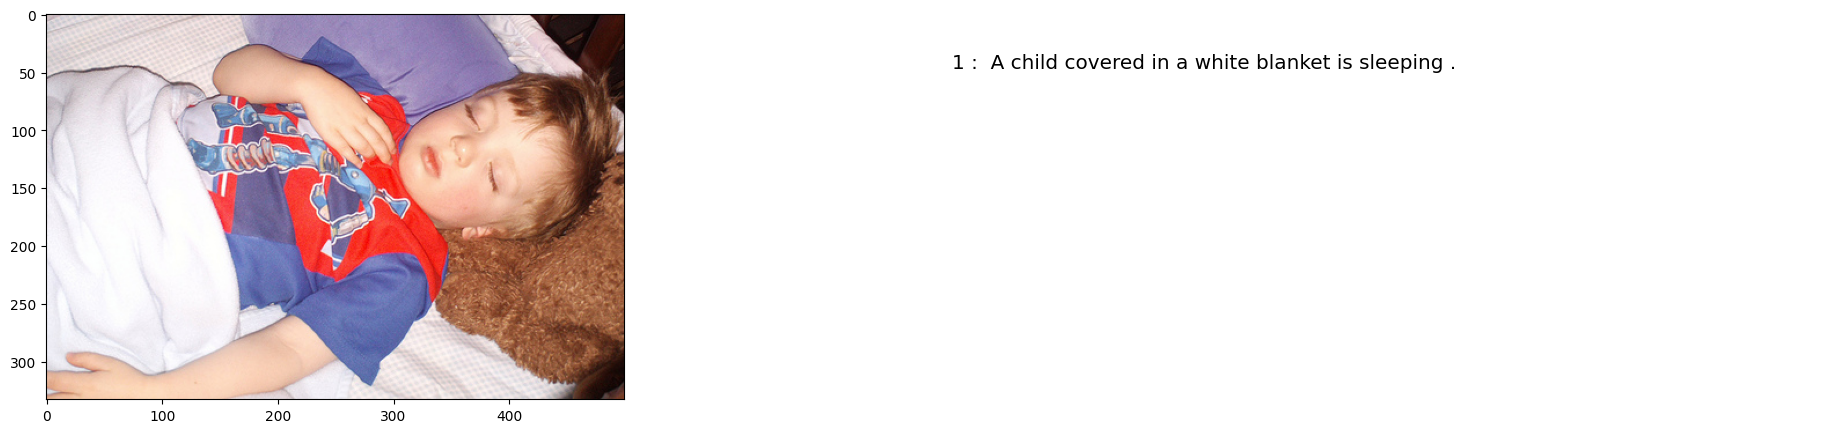

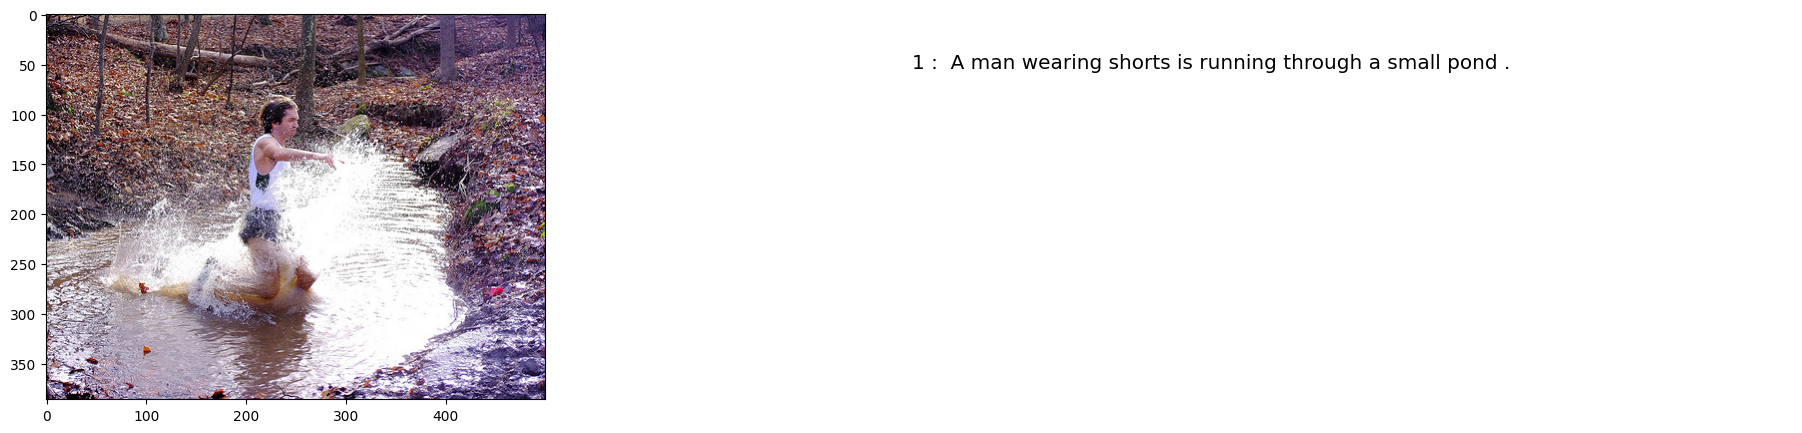

In [25]:
# Visualizing
def plot_image_with_captions(df, n: int = 3):
    for _ in range(n):
        sample_image_name = df['image_name'].sample(1).values[0]

        # Reading image
        sample_path = os.path.join(image_dir, sample_image_name)
        fig = plt.figure(figsize=(25, 5))
        ax = fig.add_subplot(1, 2, 1)
        image = plt.imread(sample_path)
        plt.imshow(image)

        # captions
        all_captions = df[df['image_name'] == sample_image_name]['comment']
        ax = fig.add_subplot(1, 2, 2)
        plt.axis('off')
        for num, caption in enumerate(all_captions.values):
            caption = f'{num+1} : {caption}'
            ax.text(0, 0.85 - num*(1/8), caption, horizontalalignment='left', verticalalignment='bottom',
                    multialignment='left', fontsize='x-large', transform=ax.transAxes)


a = plot_image_with_captions(df)


# Text preprocessing


In [26]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/t/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
# removing the words with less frequency

text_data = df['comment'].str.lower().str.cat(sep=' ')

# Tokenize the words 
words = word_tokenize(text_data) #takes 19s


In [28]:

# Get unique words
word_count = Counter(words)
# countdf = pd.DataFrame(dict(word_count), index = range(word_count))
unique_words = set(words)


In [29]:
len(word_count.keys()), len(word_count.values())

(11440, 11440)

In [30]:
# fff = [key for key in ff.keys() if ff[key]< 3]
countdf = pd.DataFrame([word_count.keys(), word_count.values()]).T
countdf.columns = ['word', 'counts']

In [31]:
countdf.sort_values('counts', ascending = False).head()

,word,counts
18,a,59902
10,.,30648
24,in,19272
45,the,14452
41,and,11150


In [32]:
_low = countdf[countdf['counts']<3]
print('shape: ',_low.shape)
print('unique: ',_low.word.unique())

shape:  (6231, 2)
unique:  ['trendy' 'tri-colored' 'tractors' ... 'port-a-potty' 'relieved'
 'straight-backed']


<AxesSubplot: ylabel='Frequency'>

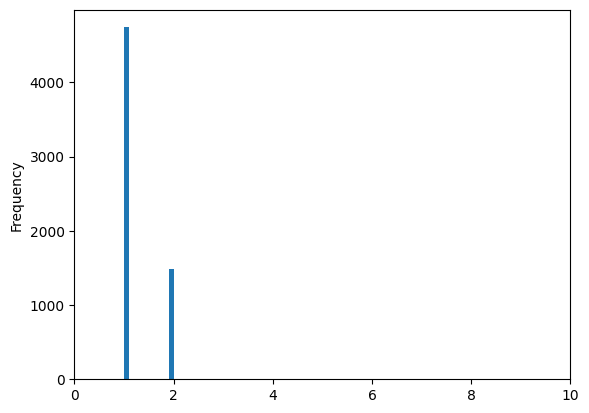

In [33]:
_low.counts.plot(kind = 'hist', xlim = [0,10])

* we will remove the word that has frequency lower than 5

In [34]:
_high = countdf[countdf['counts']>3]
print(_high.shape)
_high.sort_values('counts', ascending = True).head(10)

(4326, 2)


,word,counts
4783,salon,4
3696,temporary,4
5201,tide,4
6358,hour,4
6355,secured,4
6347,sandwiches,4
6344,competitively,4
2051,frightened,4
4302,crack,4
4312,snap,4


In [35]:
words_to_keep = _high.word.values
words_to_keep = set(words_to_keep )
print(len(words_to_keep))

4326


In [36]:

def clean_words(x):
    words = re.split(r'\W+', x)
    return ' '.join(w for w in words if w.lower() in words_to_keep)


In [37]:
df['comment'] = df['comment'].map(clean_words)
df.head()

,image_name,comment_number,comment,serial
1,1000092795.jpg,1,Two young White males are outside near many bu...,0
6,10002456.jpg,1,Workers look down from up above on a piece of ...,1
11,1000268201.jpg,1,A little girl in a pink dress going into a wooden,2
16,1000344755.jpg,1,A man in a blue shirt is standing on a ladder ...,3
21,1000366164.jpg,1,Two guy cooking and around with the camera,4


In [38]:
# adding start and end token
START_TOKEN = 'startseq'
END_TOKEN = 'endseq'


In [39]:
df.head()

,image_name,comment_number,comment,serial
1,1000092795.jpg,1,Two young White males are outside near many bu...,0
6,10002456.jpg,1,Workers look down from up above on a piece of ...,1
11,1000268201.jpg,1,A little girl in a pink dress going into a wooden,2
16,1000344755.jpg,1,A man in a blue shirt is standing on a ladder ...,3
21,1000366164.jpg,1,Two guy cooking and around with the camera,4


In [40]:
df['comment'] = START_TOKEN + ' ' + df['comment'] + ' ' + END_TOKEN


In [41]:
import regex as re

def preprocess_text(text):

    text = tf.strings.lower(text)

    text = tf.strings.regex_replace(text, r'\d', '')

    # Remove any punctuations
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(
        '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

    # Remove single characters
    text = tf.strings.regex_replace(text, r'\b\w\b', '')
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    # text = tf.strings.join([START_TOKEN, text, END_TOKEN], separator=' ')
    return text


text = ["Hello, world! This is an 😊 example 123."]
preprocessed_text = preprocess_text(text)
print(preprocessed_text.numpy()[0].decode())


hello world this is an  example


## Tokenization


max:  41
mean:  15.664946669603246
median:  15.0
std : 3.845773783695852
34.0 words covers 99.9% of the data


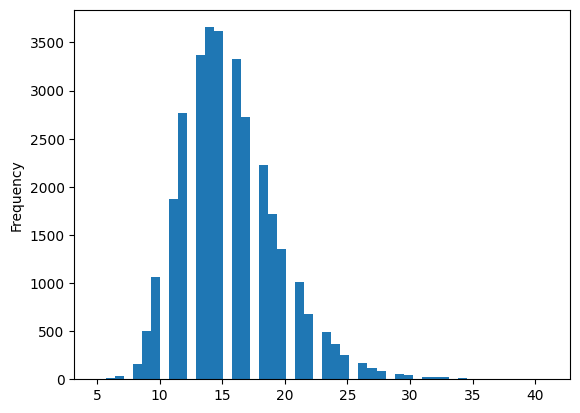

In [42]:
df['word_count'] = df['comment'].apply(lambda x: len(str(x).split()))
print('max: ', df['word_count'].max())  # 82
print('mean: ', df['word_count'].mean())
print('median: ', df['word_count'].median())
print('std :', df['word_count'].std())
df['word_count'].plot(kind='hist', bins=50)

# how much precenatage of 50 words covers
percent = 99.9
print(
    f"{np.percentile(df['word_count'], 99.9)} words covers {percent}% of the data")
# 45 token length covers 99.9 % data while 82 token length covers 100 %
# that is alot of tokens just to cover .1%
# so we will go with max_token 50
max_len = 50


In [ ]:
tokenizer = TextVectorization(standardize=preprocess_text)

'''
max_len +1 beacause later while mapping we will shift y_in, and y_out by one word so the max_len will be 50
 else it would be 49 throw error for not matchin shapes
'''

tokenizer.adapt(df['comment'])


In [ ]:
# Lookup Table
word_to_id = tf.keras.layers.StringLookup(
    vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
id_to_word = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(
), mask_token='', oov_token='[UNK]', invert=True)


In [ ]:
print('Total words: ', tokenizer.vocabulary_size())

print('least frequent words: \n')
print(*tokenizer.get_vocabulary()[-150:], '\n')

print('Most frequent words: \n')
print(*tokenizer.get_vocabulary()[:150])


# Reading Glove Embedding

In [ ]:
glove_api_command = 'kaggle datasets download -d watts2/glove6b50dtxt'
glove_url = 'https://www.kaggle.com/datasets/watts2/glove6b50dtxt'

In [ ]:
if 'google.colab' in sys.modules:

    download_kaggle_dataset(glove_api_command)
    os.makedirs('embedding', exist_ok = True)
    shutil.move('glove6b50dtxt.zip', 'embedding/glove.6B.50d.zip',)

In [ ]:
glove_path = Path("./embedding/glove.6B.50d.zip")

In [ ]:
# Embedding
def glove_embedding(path:Path) -> dict:
    # Reading glove embedding
    with ZipFile(path) as f:
        f.extractall("./embedding/")
    

    embeddings_index = {}
    with open(path.parent / "glove.6B.50d.txt", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
        f.close()

    os.remove("./embedding/glove.6B.50d.txt")
    return embeddings_index


In [ ]:
# Create matrix that holds words that occour together
def embedding_matrix_creater(EMBEDDING_DIMENSION, word_index):
    embeddings_index = glove_embedding(glove_path)
    embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIMENSION))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
word_dict = {word: i for i, word in enumerate(tokenizer.get_vocabulary())}

# Creating embedding matrix
embedding_matrix = embedding_matrix_creater(
    EMBEDDING_DIMENSION, word_index=word_dict
)

# Saving embedding_matrix for further use
np.save("./embedding/embedding_matrix.npy", embedding_matrix, allow_pickle=True)
# compressing
ZipFile("embedding_matrix.zip", mode="w").write(
    "./embedding/embedding_matrix.npy"
)

In [ ]:
embedding_matrix.shape

# Image Preprocessing


# Resnet and Efficientnet


In [ ]:
# # Downloading CNN models
# eff = tf.keras.applications.EfficientNetB6(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=tf.keras.layers.Input(shape=IMG_SHAPE),
# 	)

# eff.trainable = False


resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=IMG_SHAPE)

)

resnet.trainable = False


In [ ]:
# Creating filepath to image
df['image_path'] = str(image_dir) + '/' + df['image_name']


In [ ]:
df.head()
# df.image_path.sample(3).values


In [ ]:

@tf.function
def load_images_now(x):
    image_data = tf.io.read_file(x)
    image_features = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image_features = tf.image.resize_with_pad(
        image_features, target_height=IMG_SIZE, target_width=IMG_SIZE)
    image_features = tf.keras.applications.resnet.preprocess_input(
        image_features)
    image_features = tf.reshape(
        image_features, (1, IMG_SIZE, IMG_SIZE, CHANNELS))
    image_features = resnet(image_features)
    image_features = GlobalAveragePooling2D()(image_features)
    image_features = tf.squeeze(image_features)

    # (2048, ) remember the shape this would be input shape for image input
    return image_features


# Making dataset


In [ ]:
# TRAIN_SIZE = .5
TEST_SIZE = .05
VAL_SIZE = .05

train, val = train_test_split(
    df[['image_path', 'comment']],  test_size=VAL_SIZE, random_state=11)
train, test = train_test_split(
    train[['image_path', 'comment']],  test_size=TEST_SIZE, random_state=11)


In [ ]:
print(f'{train.shape=}')
print(f'{test.shape=}')
print(f'{val.shape=}')

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train.image_path, train.comment))
test_data = tf.data.Dataset.from_tensor_slices((test.image_path, test.comment))
val_data = tf.data.Dataset.from_tensor_slices((val.image_path, val.comment))


In [ ]:
# for i, j in train_data.take(10):
#     print(f'{i.numpy().decode():<40} {j.numpy()}')


In [ ]:
# This function loads image from given filepath ,
# tokenizes caption and arranges in y_in and y_out
def mapper(x, y):
    x = load_images_now(x)
    y = tokenizer(y)
    
    
    y_in = y[:-1]
    y_in =  tf.pad(y_in, [[0, max_len - tf.shape(y_in)[0]]] , constant_values=0)

    y_out = y[1:]
    y_out =  tf.pad(y_out, [[0, max_len - tf.shape(y_out)[0]]], constant_values=0)

    return (x, y_in), y_out


In [ ]:
train_data = train_data.map(mapper)


In [ ]:
for (img_in, txt_in), txt_out in train_data.take(3):
    # print(f'{i.numpy().decode():<40} {j.numpy()}')
    print('x     : ', img_in.shape)
    print('y_in  : ', txt_in)
    print('y_out : ', txt_out)
    print('\n')


In [ ]:
resnet_output_flattened_shape = 8*8*2048


In [ ]:
txt_in

In [ ]:
# batching and prefetching
train_data = train_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(mapper).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(mapper).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [ ]:
print("Number of training samples: %d" %
      tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" %
      tf.data.experimental.cardinality(val_data))
print("Number of test samples: %d" %
      tf.data.experimental.cardinality(test_data))


# Helper Functions


In [ ]:
# from funcyou.callbacks import create_model_checkpoint
def create_model_checkpoint(model_name, save_dir, monitor: str = 'val_loss', verbose: int = 0, save_best_only: bool = True, save_weights_only: bool = False,
                            mode: str = 'auto', save_freq='epoch', options=None, initial_value_threshold=None, **kwargs):
    # sourcery skip: avoid-builtin-shadow
    model_name = f'{model_name}-{str(datetime.datetime.now())}'
    dirs = os.path.join(save_dir, model_name)

    if not os.path.exists(dirs):
        os.makedirs(dirs)

    return tf.keras.callbacks.ModelCheckpoint(
        dirs,
        monitor=monitor,
        verbose=verbose,
        save_best_only=save_best_only,
        save_weights_only=save_weights_only,
        mode=mode,
        save_freq=save_freq,
        options=options,
        initial_value_threshold=initial_value_threshold,
        **kwargs)


## Clearing memory before running the model to free some ram


In [ ]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()), key=lambda x: -x[1],)[:15]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


In [ ]:
# del(df, train, val, counts, test)


In [ ]:
tokenizer.vocabulary_size()

# Model


In [ ]:
# write a funtion that creates a model that takes and image, and text  then pre processes it with resnet_preprocess funtion then extracts freature using resnet mdoel then calculates attention with text after
# lstm and return output
import tensorflow as tf




In [ ]:
# 
from tensorflow.keras.layers import Attention
UNITS = 8
VOCAB_SIZE = tokenizer.vocabulary_size()
EMBEDDING_DIMS = 50
max_len = 50
UNITS = 8
VOCAB_SIZE = tokenizer.vocabulary_size()
EMBEDDING_DIMS = 50
max_len = 50

# Define the get_model function
def get_model():
    encoder = LSTM(UNITS, return_sequences=True, return_state=True)
    decoder = LSTM(UNITS, return_sequences=True)

    embedding = Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIMS,
        mask_zero=True,
        input_length=max_len,
        trainable=False,
    )
    embedding.build([None])
    embedding.set_weights([embedding_matrix])

    # image inputs
    image_input = Input(shape=(2048,))
    x = Dense(UNITS * max_len)(image_input)
    x = tf.reshape(x, (-1, max_len, UNITS))
    img_model = Model(inputs=image_input, outputs=x)

    # text inputs
    txt_input = Input(shape=(max_len,))
    i = embedding(txt_input)
    i, j, k = encoder(i)
    i = Dropout(.3)(i)
    i = decoder(i, initial_state=[j, k])
    i = Dropout(.3)(i)

    # attention between x and i
    l = Attention()([x, i])
    ll = Attention()([i, x])

    # concatenate x and i
    m = Concatenate()([x, i, l, ll])
    m = Dropout(.3)(m)

    m = Dense(VOCAB_SIZE)(m)

    return Model(inputs=[img_model.input, txt_input], outputs=m), img_model




In [ ]:
model, img_model = get_model()
print(model.summary(), img_model.summary())

## Metrics and Loss


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)


In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    matchh = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(matchh)/tf.reduce_sum(mask)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

os.makedirs('log', exist_ok=True)
csv_logger = CSVLogger('./log/training.log')


In [ ]:
EPOCHS = 10
print(len(train_data), len(val_data), len(test_data))
print(int((len(train_data) / EPOCHS)), int((len(val_data) / EPOCHS)), int((len(val_data) / EPOCHS)))
steps_per_epoch = int(0.1*(len(train_data) / EPOCHS))
validation_steps =  int(.2*(len(val_data) / EPOCHS))
print(steps_per_epoch, validation_steps)

## Fitting the Model


In [ ]:
# #fit the model
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=[
                        csv_logger, create_model_checkpoint(model_name = 'capgen', save_dir = './drive/MyDrive/caption_generator', monitor = 'masked_acc')
                                ]
                    )


In [ ]:
model.save(f'/content/drive/MyDrive/caption_generator/{datetime.datetime.now()}-{EPOCHS}.h5')
# model.load_weights(f'/content/drive/MyDrive/caption_generator/{EPOCHS}.h5')


In [ ]:
hhd = test_data.take(1)
ypred2 = tf.squeeze(tf.round(model.predict(hhd,
                                           use_multiprocessing=True)))
print('ypred2.shape: ', ypred2.shape)

ytest_true = [y for x, y in hhd]
print('ypred2.shape: ', len(ytest_true))


In [ ]:
yy = tf.argmax(ypred2, axis=-1)


In [ ]:
yy.shape


# Prediction


In [ ]:
def tokens_to_text(tokens):
    words = id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, f'^ *{START_TOKEN} *', '')
    result = tf.strings.regex_replace(result, f' *{END_TOKEN} *$', '')
    return result


In [ ]:
# tokens_to_text(yy)


In [ ]:
random_image_path = test.image_path.sample(1).values[0]
random_image_path

In [ ]:
start_token = word_to_id('startseq') #2
end_token = word_to_id('endseq') #3

In [ ]:
def create_initial_input(max_len):

    # Get the word index of the word `startseq`.
    start_token = word_to_id('startseq')

    # Create a list of zeros of length `max_len`.
    initial_input = [0] * max_len

    # Set the first element of the list to the word index of the word `startseq`.
    initial_input[0] = start_token.numpy()

    initial_input = tf.reshape(initial_input,(max_len,))
    return initial_input

In [ ]:
from functools import cache

In [ ]:

# def generate_caption(image_path, model, tokenizer, temp = 0.6):
#     # # Load the image and extract its features using the ResNet model.
#     ii = plt.imread(image_path)
#     plt.imshow(ii)

#     features = load_images_now(image_path)
#     features = tf.reshape(features, (1, features.shape[0]))

#     # Generate a caption using the model.
#     start_token = 'startseq'
#     end_token = 'endseq'

#     caption_list = [start_token]

#     for _ in range(max_len):
#         caption = tf.strings.join(caption_list, ' ')
#         sequence = tokenizer([caption])
#         sequence = tf.pad(sequence, [[0, 0], [0, max_len - tf.shape(sequence)[1]]])

#         # Get the next word from the model.
#         logits = model.predict([features, sequence], verbose = 0)
#         # next_word_idx = tf.argmax(next_word_idx, axis=-1)
#         logits = logits[:, -1, :]/temp
#         # print('temlp:',logits.shape)
#         next_word_idx = tf.random.categorical(logits, num_samples=1)

#         # Convert the predicted word index to its corresponding word.
#         next_word = id_to_word(next_word_idx.numpy()[0])
#         # print(next_word)
#         # break
#         if next_word == end_token:
#             break

#         # Add the next word to the caption.
#         caption_list.append(next_word)

#     # Convert the caption from a list of words to a string.
#     # caption = ' '.join([str(word) for word in caption_list[1:]])  # Exclude the start token.
#     caption = tf.strings.join(caption, ' ')

#     return caption


In [ ]:

def generate_caption(image_path, model, tokenizer, beam_size=5):
    # Load the image and extract its features using the ResNet model.
    ii = plt.imread(image_path)
    plt.imshow(ii)

    features = load_images_now(image_path)
    features = tf.reshape(features, (1, features.shape[0]))

    # Initialize a list of beams. Each beam is a list of words that are considered to be possible captions.
    beams = [[start_token]] * beam_size

    for _ in range(max_len):
        # For each beam, add the most likely word at the current step to the beam.
        for i, beam in enumerate(beams):
            sequence = tokenizer([beam.decode('utf-8')])
            sequence = tf.pad(sequence, [[0, 0], [0, max_len - tf.shape(sequence)[1]]])

            # Get the next word from the model.
            logits = model.predict([features, sequence], verbose = 0)
            next_word_idx = tf.argmax(logits, axis=-1)

            # Convert the predicted word index to its corresponding word.
            next_word = id_to_word(next_word_idx.numpy()[0])

            # Add the next word to the beam.
            beams[i].append(next_word)

        # Sort the beams by their probability.
        beams.sort(key=lambda x: x[-1], reverse=True)

        # Keep the top k beams.
        beams = beams[:beam_size]

    # Select the beam with the highest probability as the output caption.
    caption = beams[0]
    caption = ' '.join(caption[1:])  # Exclude the start token.

    return caption

In [ ]:
def generate_caption(image_path, model, vectorizer, beam_size=5):
    # Load the image and extract its features using the ResNet model.
    ii = plt.imread(image_path)
    plt.imshow(ii)

    features = load_images_now(image_path)
    features = tf.reshape(features, (1, features.shape[0]))

    # Initialize a list of beams. Each beam is a list of words that are considered to be possible captions.
    beams = [[start_token]] * beam_size

    for _ in range(max_len):
        # For each beam, add the most likely word at the current step to the beam.
        for i, beam in enumerate(beams):
            # Convert the beam to a string.
            beam = ' '.join([str(word) for word in beam])

            # Get the next word from the model.
            logits = model.predict([features, tf.convert_to_tensor(vectorizer([beam]))], verbose = 0)
            next_word_idx = tf.argmax(logits, axis=-1)

            # Convert the predicted word index to its corresponding word.
            next_word = id_to_word(next_word_idx.numpy()[0])

            # Add the next word to the beam.
            beams[i].append(next_word)

        # Sort the beams by their probability.
        beams.sort(key=lambda x: x[-1], reverse=True)

        # Keep the top k beams.
        beams = beams[:beam_size]

    # Select the beam with the highest probability as the output caption.
    caption = beams[0]
    caption = ' '.join(caption[1:])  # Exclude the start token.

    return caption


In [ ]:
aa = generate_caption(random_image_path, model, tokenizer)
aa

In [ ]:
# def generate_caption(image_path, model, tokenizer):

#     # Load the image and extract its features using the ResNet model.
#     features = load_images_now(image_path)
#     features = tf.reshape(features, (1, features.shape[0]))

#     # Generate a caption using the model.
#     start_token_id = word_to_id('startseq').numpy()
#     start_token = 'startseq'
#     end_token_id = word_to_id('endseq')
#     end_token = 'endseq'

    
#     caption_list = [start_token, 'hello']
#     caption = tf.strings.join(caption_list, ' ')
#     # caption.append(start_token)

#     sequence = tokenizer(caption)
#     sequence = tf.pad(sequence, [[0, max_len-tf.shape(sequence)[0]]])
#     sequence = tf.reshape(sequence, (1, max_len))

#     print(features.shape, sequence.shape)

#     # x = layers.Concatenate()([features, sequence])
#     # print(x.shape)
#     # yy = model.predict((features, sequence))
#     # print(yy.shape)
#     for i in range(2):
#         # Get the next word from the model.
#         print(caption)
#         next_word_idx = model.predict([features, sequence])
        
#         print(next_word_idx.shape)
#         yy = tf.argmax(next_word_idx)
#         print(yy)
#         # print(tokens_to_text(next_word_idx))
#         break

#     #     # If the next word is the end token, stop generating.
#     #     if next_word_idx == end_token_id:
#     #         break

#     #     # Add the next word to the caption.
#     #     caption_list.append(next_word_idx)

#     # # Convert the caption from a list of indices to a string.
#     # caption = tokenizer.decode(caption)

#     # return caption, sequence
#     # # return tokens_to_text(caption)

In [ ]:
# create_initial_input(max_len)
generate_caption(random_image_path, model, tokenizer)

In [ ]:
for (img, txt_in), txt_out in train_data.unbatch():
    print(img.shape)
    print(txt_in.shape)
    print(txt_out.shape)
    break